In [2]:
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from keras.regularizers import l1, l2
from tensorflow.keras import initializers
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import KFold
import keras_tuner
import keras
from keras import layers
import itertools
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
import keras.backend as K
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from math import ceil

seed = 7
tf.random.set_seed(seed)

2022-11-29 11:19:50.159714: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-29 11:19:58.324875: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-29 11:20:10.690255: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-29 11:20:10.690566: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [3]:
def plot_curves(curve_1, label_1, curve_2=None, label_2=None):
    if curve_1 is not None: 
        plt.plot(curve_1, label = label_1)
    if curve_2 is not None: 
        plt.plot(curve_2, label = label_2)   
    plt.legend()
    plt.show()

In [4]:
scaler = None

def load_monks(path, encode):
    
    train = pd.read_csv(f"{path}.train", header=None, sep=" ")
    test = pd.read_csv(f"{path}.test", header=None, sep=" ")
    
    train.drop(0, axis=1, inplace=True)
    test.drop(0, axis=1, inplace=True)
    train.drop(8, axis=1, inplace=True)
    test.drop(8, axis=1, inplace=True)
    
    y_train = train.iloc[:, 0].to_numpy().astype(np.float64)
    x_train = train.iloc[:, 1:].to_numpy().astype(np.float64)
    y_test = test.iloc[:, 0].to_numpy().astype(np.float64)
    x_test = test.iloc[:, 1:].to_numpy().astype(np.float64)
    
        
    if encode:
        
        encoder = OneHotEncoder()
        
        encoder.fit(x_train)
        x_train = encoder.transform(x_train).toarray()
        
        encoder.fit(x_test)
        x_test = encoder.transform(x_test).toarray()
        
        
    
    print(f"Loaded {path} dataset")
    
    return x_train, y_train, x_test, y_test
    

def load_cup(scale):
    global scaler
    
    # scaler = StandardScaler()
    scaler = MinMaxScaler()
    
    train = pd.read_csv("../data/ML-CUP22-TR.csv", header=None, sep=",")
    test = pd.read_csv("../data/ML-CUP22-TS.csv", header=None, sep=",")
    train.drop(0, axis=1, inplace=True)
    test.drop(0, axis=1, inplace=True)

    y_train = train.iloc[:, 9:].to_numpy().astype(np.float64)
    x_train = train.iloc[:, :9].to_numpy().astype(np.float64)
    x_test_blind = test.to_numpy().astype(np.float64)
    
    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, shuffle=True, random_state=7)
    
    if scale:
        # scaler = MinMaxScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.fit_transform(x_test)
        y_train = scaler.fit_transform(y_train)
        
        
    return x_train, y_train, x_test, y_test, x_test_blind
    
    
    
def load_dataset(dataset, encode=True):
    assert dataset in ["monks1", "monks2", "monks3", "cup"]
    
    if dataset == "monks1":
        return load_monks("./../data/monks-1", encode)
    elif dataset == "monks2":
        return load_monks("./../data/monks-2", encode)
    elif dataset == "monks3":
        return load_monks("./../data/monks-3", encode)
    else:
        return load_cup(encode)

In [5]:
def median_index(array):
    n = len(array)
    med_idx = np.argsort(array)[ceil((n-1)/2)]
    # med_val = array[med_idx]
    return med_idx #, med_val

def mee(y_true_t, y_pred_t):
    '''y_true = y_true_t.numpy()
    y_pred = y_pred_t.numpy()
    y_true = scaler.inverse_transform(y_true)
    y_pred = scaler.inverse_transform(y_pred)
    return np.sqrt(np.square(y_true - y_pred).sum(axis=1)).mean()'''
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(y_true_t - y_pred_t), axis=1)))

def merge_dicts(dicts):
    merged = {}
    for d in dicts:
        merged = {**merged, **d}
    return merged


def get_attributes_num(dataset):
    return 1 if len(dataset.shape) == 1 else dataset.shape[1]


def get_params_configurations(params):
    
    keys = list(params.keys())
    keys.remove("layers")
    keys.remove("task")
    keys.remove("initialization")
    keys.remove("early_stopping")
    keys.remove("regularization")
    keys.remove("nesterov")
    keys.remove("trials_train")
    keys.remove("trials_test")
    keys.remove("learning_rate_decay")
    sorted_keys = sorted(keys)
    arguments = []
    for key in sorted_keys:
        arguments.append(params[key])
    
    arguments = tuple(arguments)
    all_params = list(itertools.product(*arguments))
        
    configurations = []
    
    for conf in all_params:
        
        dict_conf = {}
        
        for i in range(len(sorted_keys)):
            dict_conf[sorted_keys[i]] = conf[i]
        dict_conf["initialization"] = params["initialization"]
        dict_conf["early_stopping"] = params["early_stopping"]
        dict_conf["task"] = params["task"]
        dict_conf["trials_train"] = params["trials_train"]
        dict_conf["trials_test"] = params["trials_test"]
        dict_conf["nesterov"] = params["nesterov"]
        dict_conf["learning_rate_decay"] = params["learning_rate_decay"]
        
        # add regularization parameters
        for reg in params["regularization"]:
            method = reg["type"]
            
            if method == None:
                reg_dict_conf = dict_conf.copy()
                reg_dict_conf["regularization"] = {
                    "method": None
                }
                configurations.append(reg_dict_conf)
                continue
            
            for val in reg["value"]:
                reg_dict_conf = dict_conf.copy()
                reg_dict_conf["regularization"] = {
                    "method": method,
                    "value": val
                }
        
                configurations.append(reg_dict_conf)
            
        
    return configurations


def get_callbacks(config):
    
    lr_decay = config["learning_rate_decay"]
    early_stopping = config["early_stopping"]
    
    callbacks = []
    
    if early_stopping != None:
        early_stop = EarlyStopping(
            monitor=early_stopping["monitor"], 
            patience=early_stopping["patience"], 
            min_delta=early_stopping["delta"], 
        )
        callbacks.append(early_stop)

    if lr_decay != None:
        decay_epochs = lr_decay["epochs"]
        lr_final = lr_decay["lr_final"]
        linear_scheduler = get_linear_scheduler(decay_epochs, lr_final)
        scheduler = LearningRateScheduler(linear_scheduler)
        callbacks.append(scheduler)
        
    return callbacks if callbacks != [] else None
        


def get_layers_configurations(params, configurations):
    layers = params["layers"]
    layers_params_confs = []
    
    for n_layer in range(len(layers)):
        layers_params_confs.append([]) 
    
    for i in range(len(layers)):
        layer = layers[i]
        activations = layer["activations"]
        units = layer["units"]
        layer_confs = list(itertools.product(activations, units))
        for conf in layer_confs:
            conf_dict = {
                f"activations_{i+1}": conf[0],
                f"units_{i+1}": conf[1]
            }
            layers_params_confs[i].append(conf_dict)
        
    layers_confs = []
    for i in range(len(layers_params_confs)):
        confs = layers_params_confs[:i+1]
        confs = tuple(confs)
        confs = list(itertools.product(*confs))
        for conf in confs:
            layers_confs.append(merge_dicts(conf))
                
    return layers_confs



def get_configurations(params):
    
    configurations = get_params_configurations(params)
    layers_confs = get_layers_configurations(params, configurations)
    configurations = list(itertools.product(configurations, layers_confs))
    configurations_merged = []
    
    for conf in configurations:
        configurations_merged.append(merge_dicts(conf))
        
    
    return configurations_merged

            

def get_linear_scheduler(epochs, lr_final):
    
    def linear_scheduler(epoch, lr):
        if (epoch < epochs):
            alpha = epoch/epochs
            return (1-alpha)*lr + alpha*lr_final
        else:
            return lr_final
        
    return linear_scheduler
    

def get_model(config, input_size, output_size):
    
    lr = config["learning_rate"]
    momentum = config["momentum"]
    init_method = config["initialization"]["type"]
    task = config["task"]
    nesterov = config["nesterov"]
    
    reg_method = config["regularization"]["method"]
    
    if reg_method == "l1":
        reg_value = config["regularization"]["value"]
        reg = l1(reg_value)
    elif reg_method == "l2":
        reg_value = config["regularization"]["value"]
        reg = l2(reg_value)
    else:
        reg = None
    
    
    init = None
    if init_method == "uniform":
        min_val = config["initialization"]["min"]
        max_val = config["initialization"]["max"]
        init = initializers.RandomUniform(minval=min_val, maxval=max_val, seed=None)
    if init_method == "normal":
        mean = config["initialization"]["mean"]
        std = config["initialization"]["std"]
        init = initializers.RandomNormal(mean=mean, stddev=std, seed=None)
        
    
    optimizer = SGD(learning_rate=lr, momentum=momentum, nesterov=nesterov)
    
    n_layers = 0
    for key in config.keys():
        if key.startswith("units_"):
            n_layers += 1

    model = Sequential()
    
    activation = config["activations_1"]
    n_units = config["units_1"]
    model.add(Dense(n_units, input_dim=input_size, activation=activation,
                    kernel_regularizer=reg, bias_regularizer=reg,
                    kernel_initializer = init, bias_initializer = init))
    
    for l in range(2,n_layers+1):
        activation = config[f"activations_{l}"]
        n_units = config[f"units_{l}"]
        
        model.add(Dense(n_units, activation=activation,
                        kernel_regularizer=reg, bias_regularizer=reg,
                        kernel_initializer = init, bias_initializer = init))
        
        
    if task == "classification":
        model.add(Dense(output_size, activation="sigmoid",
                        kernel_regularizer=reg, bias_regularizer=reg,
                        kernel_initializer = init, bias_initializer = init))
        
        model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])
        
    elif task == "regression":
        model.add(Dense(output_size, activation="linear",
                        kernel_regularizer=reg, bias_regularizer=reg,
                        kernel_initializer = init, bias_initializer = init))
        
        model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = [mee])
        
    return model
    
    
def fit_model_k_fold(x_train, y_train, config, n_folds):
    
    task = config["task"]
    
    if task == "classification":
        train_metric = "accuracy"
        val_metric = "val_accuracy"
    elif task == "regression":
        train_metric = "mee"
        val_metric = "val_mee"
    
    trials = config["trials_train"]
    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    
    callbacks = get_callbacks(config)

    
    kf = KFold(n_splits = n_folds, shuffle=True)

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    fold = 1
    for train_index, val_index in kf.split(x_train, y_train):
        
        print(f"\nExecuting fold {fold}/{n_folds}")
        
        input_size = get_attributes_num(x_train)
        output_size = get_attributes_num(y_train)
        
                
        x_train_fold = x_train[train_index]
        y_train_fold = y_train[train_index]

        x_val_fold = x_train[val_index]
        y_val_fold = y_train[val_index]

        
        trials_val_loss = []
        trials_train_loss = []
        trials_val_acc = []
        trials_train_acc = []
        
        with tqdm(total=trials) as pbar:
            for trial in range(trials):
                model = get_model(config, input_size, output_size)
                history = model.fit(x_train_fold, y_train_fold, epochs=max_epochs,
                                    validation_data=(x_val_fold, y_val_fold),
                                    callbacks=callbacks, verbose = 0)

                trial_train_loss = history.history["loss"]
                trial_val_loss = history.history["val_loss"]         
                trial_train_acc = history.history[train_metric]
                trial_val_acc = history.history[val_metric]

                trials_val_loss.append(trial_val_loss[-1])
                trials_train_loss.append(trial_train_loss[-1])
                trials_val_acc.append(trial_val_acc[-1])
                trials_train_acc.append(trial_train_acc[-1])

                pbar.update(1)
            
        # get the median metrics among the trials
        med_idx = median_index(trials_val_loss)
        med_val_loss = trials_val_loss[med_idx]
        med_train_loss = trials_train_loss[med_idx]
        med_val_acc = trials_val_acc[med_idx]
        med_train_acc = trials_train_acc[med_idx]
        std_val_loss = np.std(trials_val_loss)
        std_train_loss = np.std(trials_train_loss)
        std_val_acc = np.std(trials_val_acc)
        std_train_acc = np.std(trials_train_acc)

        print(f"Fold {fold}/{n_folds} median val_loss: {med_val_loss}, std val_loss {std_val_loss}")
        print(f"Fold {fold}/{n_folds} median train_loss: {med_train_loss}, std train_loss {std_train_loss}")
        print(f"Fold {fold}/{n_folds} median {val_metric}: {med_val_acc}, std {val_metric} {std_val_acc}")
        print(f"Fold {fold}/{n_folds} median train_{train_metric}: {med_train_acc}, train_{train_metric} {std_train_acc}")
            
        train_losses.append(med_train_loss)
        val_losses.append(med_val_loss)
        val_accs.append(med_val_acc)
        train_accs.append(med_train_acc)
        
        fold += 1
        
    mean_train_loss = np.mean(train_losses)
    mean_val_loss = np.mean(val_losses)
    mean_train_acc = np.mean(train_accs)
    mean_val_acc = np.mean(val_accs)
    std_train_loss = np.std(train_losses)
    std_val_loss = np.std(val_losses)
    std_train_acc = np.std(train_accs)
    std_val_acc = np.std(val_accs)
    
    print(f"\nMean val_loss: {mean_val_loss}, std val_loss: {std_val_loss}")
    print(f"Mean train_loss: {mean_train_loss}, std train_loss: {std_train_loss}")
    print(f"Mean {val_metric}: {mean_val_acc}, std {val_metric}: {std_val_acc}")
    print(f"Mean train_{train_metric}: {mean_val_acc}, std train_{train_metric}: {std_train_acc}")
    
    return mean_val_loss




def fit_model_hold_out(x_train, y_train, config, val_split):
    
    task = config["task"]
    
    if task == "classification":
        train_metric = "accuracy"
        val_metric = "val_accuracy"
    elif task == "regression":
        train_metric = "mee"
        val_metric = "val_mee"
        
    trials = config["trials_train"]
    input_size = get_attributes_num(x_train)
    output_size = get_attributes_num(y_train)
    
    
    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]

    
    callbacks = get_callbacks(config)
    
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_split, shuffle=True)

    
    trials_val_loss = []
    trials_train_loss = []
    trials_val_acc = []
    trials_train_acc = []
        
    with tqdm(total=trials) as pbar:
        for trial in range(trials):            
            model = get_model(config, input_size, output_size)
            history = model.fit(x_train, y_train, epochs=max_epochs, batch_size=batch_size,
                                verbose=0, validation_data=(x_val, y_val), callbacks=callbacks)
            

            trial_train_loss = history.history["loss"]
            trial_val_loss = history.history["val_loss"]         
            trial_train_acc = history.history[train_metric]
            trial_val_acc = history.history[val_metric]
            
            trials_val_loss.append(trial_val_loss[-1])
            trials_train_loss.append(trial_train_loss[-1])
            trials_val_acc.append(trial_val_acc[-1])
            trials_train_acc.append(trial_train_acc[-1])
            
            pbar.update(1)
    
    # get the median metrics among the trials
    med_idx = median_index(trials_val_loss)
    med_val_loss = trials_val_loss[med_idx]
    med_train_loss = trials_train_loss[med_idx]
    med_val_acc = trials_val_acc[med_idx]
    med_train_acc = trials_train_acc[med_idx]
    std_val_loss = np.std(trials_val_loss)
    std_train_loss = np.std(trials_train_loss)
    std_val_acc = np.std(trials_val_acc)
    std_train_acc = np.std(trials_train_acc)

    print(f"Median val_loss: {med_val_loss}, std val_loss {std_val_loss}")
    print(f"Median train_loss: {med_train_loss}, std train_loss {std_train_loss}")
    print(f"Median {val_metric}: {med_val_acc}, std {val_metric} {std_val_acc}")
    print(f"Median train_{train_metric}: {med_train_acc}, train_{train_metric} {std_train_acc}")
    
    return med_val_loss
    
    
def fit_model_test(x_train, y_train, x_test, y_test, config):
    
    task = config["task"]
    trails = config["trials_test"]
    
    if task == "classification":
        train_metric = "accuracy"
        test_metric = "val_accuracy"
    elif task == "regression":
        train_metric = "mee"
        test_metric = "val_mee"

    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    trials = config["trials_test"]
    
    if config["early_stopping"]["monitor"] == "val_loss":
        config["early_stopping"]["monitor"] = "loss"
        
    callbacks = get_callbacks(config)
    
    input_size = get_attributes_num(x_train)
    output_size = get_attributes_num(y_train)
    
    
    trials_test_loss = []
    trials_train_loss = []
    trials_test_acc = []
    trials_train_acc = []
    
    trials_history_test_loss = []
    trials_history_train_loss = []
    trials_history_test_acc = []
    trials_history_train_acc = []   
    
    models = []
    
    with tqdm(total=trials) as pbar:
        for trial in range(trials):
            model = get_model(config, input_size, output_size)
            history = model.fit(x_train, y_train, epochs=max_epochs, validation_data=(x_test, y_test),
                                batch_size=batch_size, verbose=0, callbacks=callbacks)

            models.append(model)

            trial_train_loss = history.history["loss"]
            trial_test_loss = history.history["val_loss"]         
            trial_train_acc = history.history[train_metric]
            trial_test_acc = history.history[test_metric]

            trials_test_loss.append(trial_test_loss[-1])
            trials_train_loss.append(trial_train_loss[-1])
            trials_test_acc.append(trial_test_acc[-1])
            trials_train_acc.append(trial_train_acc[-1])

            trials_history_test_loss.append(trial_test_loss)
            trials_history_train_loss.append(trial_train_loss)
            trials_history_test_acc.append(trial_test_acc)
            trials_history_train_acc.append(trial_train_acc)

            print(f"Trial {trial+1}/{trials} test_loss: {trial_test_loss[-1]}")
            print(f"Trial {trial+1}/{trials} train_loss: {trial_train_loss[-1]}")
            print(f"Trial {trial+1}/{trials} {test_metric}: {trial_test_acc[-1]}")
            print(f"Trial {trial+1}/{trials} train_{train_metric}: {trial_train_acc[-1]}")

            pbar.update(1)
        
    med_idx = median_index(trials_test_loss)
    med_test_loss = trials_test_loss[med_idx]
    med_train_loss = trials_train_loss[med_idx]
    med_test_acc = trials_test_acc[med_idx]
    med_train_acc = trials_train_acc[med_idx]
    std_test_loss = np.std(trials_test_loss)
    std_train_loss = np.std(trials_train_loss)
    std_test_acc = np.std(trials_test_acc)
    std_train_acc = np.std(trials_train_acc)
    
    print(f"\nMedian test_loss: {med_test_loss}, std test_loss {std_test_loss}")
    print(f"Median train_loss: {med_train_loss}, std train_loss {std_train_loss}")
    print(f"Median test_{train_metric}: {med_test_acc}, std test_{train_metric} {std_test_acc}")
    print(f"Median train_{train_metric}: {med_train_acc}, std train_{train_metric} {std_train_acc}")
        
    
        
    train_acc = trials_history_train_acc[med_idx]
    test_acc = trials_history_test_acc[med_idx]
    plot_curves(train_acc, f"Training {train_metric}", test_acc, f"Test {train_metric}")
    
    train_loss = trials_history_train_loss[med_idx]
    test_loss = trials_history_test_loss[med_idx]
    plot_curves(train_loss, "Train loss", test_loss, "Test loss")
    
    med_model = models[med_idx]
    
    return med_model


def fit_model_no_test(x_train, y_train, config):
    task = config["task"]
    trails = config["trials_test"]
    
    if task == "classification":
        train_metric = "accuracy"
    elif task == "regression":
        train_metric = "mee"

    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    early_stopping = config["early_stopping"]
    trials = config["trials_test"]
    
    if config["early_stopping"]["monitor"] == "val_loss":
        config["early_stopping"]["monitor"] = "loss"
        
    callbacks = get_callbacks(config)
    
    input_size = get_attributes_num(x_train)
    output_size = get_attributes_num(y_train)
    
    
    trials_train_loss = []
    trials_train_acc = []
    
    trials_history_train_loss = []
    trials_history_train_acc = []   
    
    models = []
    
    with tqdm(total=trials) as pbar:
        for trial in range(trials):
            model = get_model(config, input_size, output_size)
            history = model.fit(x_train, y_train, epochs=max_epochs,
                                batch_size=batch_size, verbose=0, callbacks=callbacks)

            models.append(model)

            trial_train_loss = history.history["loss"]
            trial_train_acc = history.history[train_metric]

            trials_train_loss.append(trial_train_loss[-1])
            trials_train_acc.append(trial_train_acc[-1])

            trials_history_train_loss.append(trial_train_loss)
            trials_history_train_acc.append(trial_train_acc)

            print(f"Trial {trial+1}/{trials} train_loss: {trial_train_loss}")
            print(f"Trial {trial+1}/{trials} train_{train_metric}: {trial_train_acc}")

            pbar.update(1)
        
    med_idx = median_index(trials_train_loss)
    med_train_loss = trials_train_loss[med_idx]
    med_train_acc = trials_train_acc[med_idx]
    std_train_loss = np.std(trials_train_loss)
    std_train_acc = np.std(trials_train_acc)
    
    print(f"\nMedian train_loss: {med_train_loss}, std train_loss {std_train_loss}")
    print(f"Median train_{train_metric}: {med_train_acc}, std train_{train_metric} {std_train_acc}")
    
        
    
        
    train_acc = trials_history_train_acc[med_idx]
    plot_curves(train_acc, f"Training {train_metric}")
    
    train_loss = trials_history_train_loss[med_idx]
    plot_curves(train_loss, f"Train loss")
    
    med_model = models[med_idx]
    
    return med_model

    
def fit_model(x_train, y_train, config, validation):
    if validation["type"] == "k-fold":
        val_loss = fit_model_k_fold(x_train, y_train, config, validation["n_folds"])
    elif validation["type"] == "hold-out":
        val_loss = fit_model_hold_out(x_train, y_train, config, validation["val_split"])
    return val_loss



def test_model(model, x_test, y_test):
    input_size = x_test.shape[1]
    result = model.evaluate(x_test, y_test)
    print(result)

    
    
def model_selection(configurations, x_train, y_train, validation):
        
    best_loss = float("inf")
    best_conf = None
    
    idx = 1
    n_confs = len(configurations)
    for config in configurations:

        print(f"Testing configuration {idx}/{n_confs}:\n{config}")
        val_loss = fit_model(x_train, y_train, config, validation)

        if val_loss < best_loss:
            best_loss = val_loss;
            best_conf = config
        idx += 1
        
        print("\n\n")

            
    print("\n\n")
    print(f"Best configuration (loss {best_loss}):\n{best_conf}")
    
    return best_conf
    

def grid_search(params, x_train, y_train, validation={"type": "hold-out", "val_split": 0.2}, x_test=None, y_test=None ):
    configurations = get_configurations(params)    
    best_conf = model_selection(configurations, x_train, y_train, validation)
    if x_test is None:
        model = fit_model_no_test(x_train, y_train, best_conf)
    else:
        model = fit_model_test(x_train, y_train, x_test, y_test, best_conf)
        
    return model

In [6]:
params = {
    "task": "classification",
    "trials_train": 5,
    "trials_test": 10,
    "initialization": {
        "type": "uniform",
        "min": -0.5,
        "max": 0.5
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.001
    },
    "max_epochs": [500],
    "learning_rate": [0.1],
    "batch_size": [None],
    "momentum": [0.9],
    "nesterov": False,
    "learning_rate_decay": None,
    "regularization": [
        {
            "type": None
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [5],
        },
    ]
}


"""params = {
    "initialization": {
        "type": "uniform",
        "min": -0.5,
        "max": 0.5
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.001
    },
    "max_epochs": 500,
    "learning_rate": [0.001, 0.01, 0.1],
    "batch_size": [None],
    "momentum": [0.1, 0.9],
    "learning_rate_decay": {
        "epochs": 50,
        "lr_final": 0.01
    },
    "regularization": [
        {
            "type": "l1",
            "value": [0.0001, 0.001]
        },
        {
            "type": "l2",
            "value": [0.0001, 0.001]
        },
        {
            "type": None
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [1,4,8],
        },
    ]
}"""

k_fold_val = {
    "type": "k-fold",
    "n_folds": 5
}

hold_out_val = {
    "type": "hold-out",
    "val_split": 0.15
}

# Monks 1

In [208]:
x_train, y_train, x_test, y_test = load_dataset("monks1", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Loaded ./../data/monks-1 dataset
(124, 17) (124,)
(432, 17) (432,)


In [209]:
model = grid_search(params, x_train, y_train, k_fold_val, x_test, y_test)
test_model(model, x_test, y_test)

Testing configuration 1/3:
{'batch_size': None, 'learning_rate': 0.01, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'loss', 'patience': 20, 'delta': 0.1}, 'task': 'regression', 'trials_train': 5, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 10}

Executing fold 1/5


  0%|                                                     | 0/5 [00:02<?, ?it/s]


KeyboardInterrupt: 

# Monks 2

In [138]:
x_train, y_train, x_test, y_test = load_dataset("monks2", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Loaded ./../data/monks-2 dataset
(169, 17) (169,)
(432, 17) (432,)


In [139]:
model = grid_search(params, x_train, y_train, k_fold_val, x_test, y_test)
test_model(model, x_test, y_test)

Testing configuration 1/1:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.25, 'max': 0.25}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.001}, 'task': 'classification', 'trials_train': 5, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 5}

Executing fold 1/5


  0%|                                                     | 0/5 [00:04<?, ?it/s]


KeyboardInterrupt: 

# Monks 3

In [140]:
x_train, y_train, x_test, y_test = load_dataset("monks3", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Loaded ./../data/monks-3 dataset
(122, 17) (122,)
(432, 17) (432,)


Testing configuration 1/1:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.25, 'max': 0.25}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.001}, 'task': 'classification', 'trials_train': 5, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 5}


100%|█████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


Median val_loss: 0.019020985811948776, std val_loss 0.0031367731866367254
Median train_loss: 0.04647913575172424, std train_loss 0.003120822505982199
Median val_accuracy: 1.0, std val_accuracy 0.025784091797646482
Median train_accuracy: 0.9320388436317444, train_accuracy 0.006140341494283826






Best configuration (loss 0.019020985811948776):
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.25, 'max': 0.25}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.001}, 'task': 'classification', 'trials_train': 5, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 5}


 10%|████▍                                       | 1/10 [00:06<01:02,  6.93s/it]

Trial 1/10 test_loss: 0.05566086620092392
Trial 1/10 train_loss: 0.03606105595827103
Trial 1/10 val_accuracy: 0.9305555820465088
Trial 1/10 accuracy: 0.9590163826942444


 20%|████████▊                                   | 2/10 [00:15<01:03,  7.89s/it]

Trial 2/10 test_loss: 0.05924693122506142
Trial 2/10 train_loss: 0.0313311405479908
Trial 2/10 val_accuracy: 0.9305555820465088
Trial 2/10 accuracy: 0.9754098653793335


 30%|█████████████▏                              | 3/10 [00:27<01:08,  9.83s/it]

Trial 3/10 test_loss: 0.03894975036382675
Trial 3/10 train_loss: 0.003738481318578124
Trial 3/10 val_accuracy: 0.9467592835426331
Trial 3/10 accuracy: 1.0


 40%|█████████████████▌                          | 4/10 [00:32<00:46,  7.78s/it]

Trial 4/10 test_loss: 0.05174844712018967
Trial 4/10 train_loss: 0.039974380284547806
Trial 4/10 val_accuracy: 0.9398148059844971
Trial 4/10 accuracy: 0.9590163826942444


 50%|██████████████████████                      | 5/10 [00:40<00:39,  7.98s/it]

Trial 5/10 test_loss: 0.044262852519750595
Trial 5/10 train_loss: 0.012763612903654575
Trial 5/10 val_accuracy: 0.9513888955116272
Trial 5/10 accuracy: 0.9918032884597778


 60%|██████████████████████████▍                 | 6/10 [00:54<00:39,  9.98s/it]

Trial 6/10 test_loss: 0.041942477226257324
Trial 6/10 train_loss: 0.006131064612418413
Trial 6/10 val_accuracy: 0.9375
Trial 6/10 accuracy: 1.0


 70%|██████████████████████████████▊             | 7/10 [01:04<00:29,  9.84s/it]

Trial 7/10 test_loss: 0.049472592771053314
Trial 7/10 train_loss: 0.020301971584558487
Trial 7/10 val_accuracy: 0.9375
Trial 7/10 accuracy: 0.9836065769195557


 80%|███████████████████████████████████▏        | 8/10 [01:17<00:21, 10.88s/it]

Trial 8/10 test_loss: 0.044548939913511276
Trial 8/10 train_loss: 0.0047750999219715595
Trial 8/10 val_accuracy: 0.9351851940155029
Trial 8/10 accuracy: 1.0


 90%|███████████████████████████████████████▌    | 9/10 [01:31<00:11, 11.87s/it]

Trial 9/10 test_loss: 0.0490146242082119
Trial 9/10 train_loss: 0.019759129732847214
Trial 9/10 val_accuracy: 0.9398148059844971
Trial 9/10 accuracy: 0.9836065769195557


100%|███████████████████████████████████████████| 10/10 [01:41<00:00, 10.14s/it]

Trial 10/10 test_loss: 0.05697735771536827
Trial 10/10 train_loss: 0.0315764881670475
Trial 10/10 val_accuracy: 0.9328703880310059
Trial 10/10 accuracy: 0.9754098653793335

Median test_loss: 0.049472592771053314, std test_loss 0.00643053759280167
Median train_loss: 0.020301971584558487, std train_loss 0.012869839687021482
Median test_accuracy: 0.9375, std test_accuracy 0.0063856969804543294
Median train_accuracy: 0.9836065769195557, std train_accuracy 0.014867507194373976


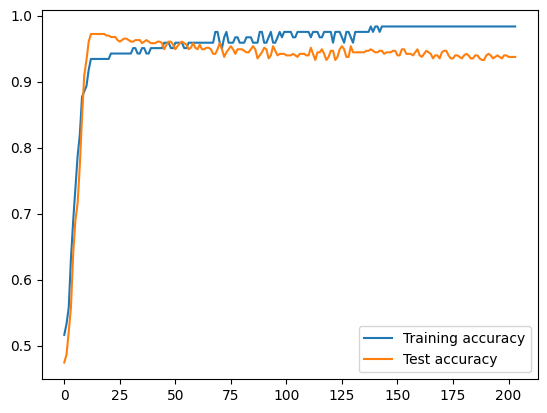

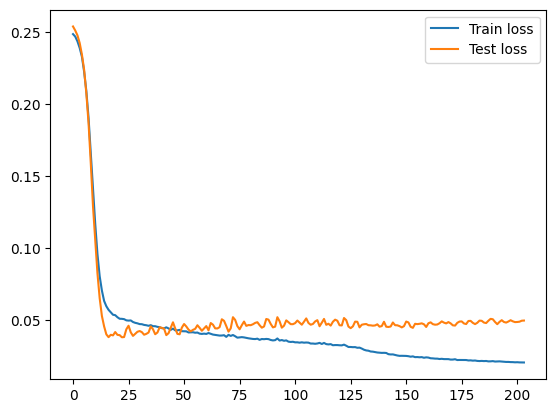

14/14 [==============================] - 0s 1ms/step - loss: 0.0495 - accuracy: 0.9375
[0.049472592771053314, 0.9375]


In [141]:
model = grid_search(params, x_train, y_train, hold_out_val, x_test, y_test)
test_model(model, x_test, y_test)

# ML Cup

In [7]:
x_train, y_train, x_test, y_test, x_test_blind = load_dataset("cup", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_test_blind.shape)

(1342, 9) (1342, 2)
(150, 9) (150, 2)
(529, 9)


In [8]:
params = {
    "task": "regression",
    "trials_train": 5,
    "trials_test": 10,
    "initialization": {
        "type": "uniform",
        "min": -0.5,
        "max": 0.5
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.1
    },
    "max_epochs": [500],
    "learning_rate": [0.01],
    "batch_size": [None],
    "nesterov": False,
    "momentum": [0.9],
    "learning_rate_decay": None,
    "regularization": [
        {
            "type": "l1",
            "value": [0.01]
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [10],
        },
        
    ]
}


k_fold_val = {
    "type": "k-fold",
    "n_folds": 5
}

hold_out_val = {
    "type": "hold-out",
    "val_split": 0.15
}

Testing configuration 1/1:
{'batch_size': None, 'learning_rate': 0.01, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.1}, 'task': 'regression', 'trials_train': 5, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 10}


  0%|                                                     | 0/5 [00:00<?, ?it/s]2022-11-29 11:20:38.792886: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-29 11:20:39.803405: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-11-29 11:20:39.803477: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-11-29 11:20:39.875397: I tensorflow/core/platform/cpu_feature_guard.cc:193] Thi

Median val_loss: 0.053403884172439575, std val_loss 0.003787920523159034
Median train_loss: 0.05302891135215759, std train_loss 0.0037645440483818028
Median val_mee: 0.18255911767482758, std val_mee 0.0027907634646628502
Median train_mee: 0.17683812975883484, train_mee 0.004288869330229427






Best configuration (loss 0.053403884172439575):
{'batch_size': None, 'learning_rate': 0.01, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.1}, 'task': 'regression', 'trials_train': 5, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 10}


 10%|████▍                                       | 1/10 [00:04<00:37,  4.21s/it]

Trial 1/10 test_loss: 437.5089111328125
Trial 1/10 train_loss: 0.05953674018383026
Trial 1/10 val_mee: 29.04631996154785
Trial 1/10 train_mee: 0.1858978271484375


 20%|████████▊                                   | 2/10 [00:07<00:30,  3.86s/it]

Trial 2/10 test_loss: 438.0882263183594
Trial 2/10 train_loss: 0.0619131438434124
Trial 2/10 val_mee: 29.066736221313477
Trial 2/10 train_mee: 0.18460996448993683


 30%|█████████████▏                              | 3/10 [00:10<00:23,  3.29s/it]

Trial 3/10 test_loss: 437.21630859375
Trial 3/10 train_loss: 0.05553711578249931
Trial 3/10 val_mee: 29.0382022857666
Trial 3/10 train_mee: 0.17964041233062744


 40%|█████████████████▌                          | 4/10 [00:13<00:18,  3.06s/it]

Trial 4/10 test_loss: 437.1927185058594
Trial 4/10 train_loss: 0.0521719716489315
Trial 4/10 val_mee: 29.04061508178711
Trial 4/10 train_mee: 0.17633943259716034


 50%|██████████████████████                      | 5/10 [00:16<00:15,  3.03s/it]

Trial 5/10 test_loss: 437.69024658203125
Trial 5/10 train_loss: 0.06158183887600899
Trial 5/10 val_mee: 29.052082061767578
Trial 5/10 train_mee: 0.186703622341156


 60%|██████████████████████████▍                 | 6/10 [00:18<00:11,  2.92s/it]

Trial 6/10 test_loss: 437.82806396484375
Trial 6/10 train_loss: 0.06356179714202881
Trial 6/10 val_mee: 29.057796478271484
Trial 6/10 train_mee: 0.18352721631526947


 70%|██████████████████████████████▊             | 7/10 [00:21<00:08,  2.81s/it]

Trial 7/10 test_loss: 437.88165283203125
Trial 7/10 train_loss: 0.05713144317269325
Trial 7/10 val_mee: 29.059680938720703
Trial 7/10 train_mee: 0.18593637645244598


 80%|███████████████████████████████████▏        | 8/10 [00:24<00:05,  2.77s/it]

Trial 8/10 test_loss: 437.09417724609375
Trial 8/10 train_loss: 0.05626508966088295
Trial 8/10 val_mee: 29.034114837646484
Trial 8/10 train_mee: 0.17945310473442078


 90%|███████████████████████████████████████▌    | 9/10 [00:27<00:03,  3.03s/it]

Trial 9/10 test_loss: 437.80084228515625
Trial 9/10 train_loss: 0.061687007546424866
Trial 9/10 val_mee: 29.05584144592285
Trial 9/10 train_mee: 0.18889358639717102


100%|███████████████████████████████████████████| 10/10 [00:30<00:00,  3.06s/it]

Trial 10/10 test_loss: 437.3060302734375
Trial 10/10 train_loss: 0.061765991151332855
Trial 10/10 val_mee: 29.03946876525879
Trial 10/10 train_mee: 0.18369288742542267

Median test_loss: 437.69024658203125, std test_loss 0.3265619259126536
Median train_loss: 0.06158183887600899, std train_loss 0.003472364235577075
Median test_mee: 29.052082061767578, std test_mee 0.01033807270179442
Median train_mee: 0.186703622341156, std train_mee 0.0036721602572107968


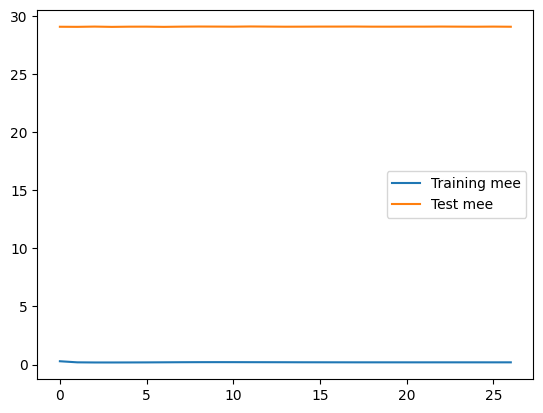

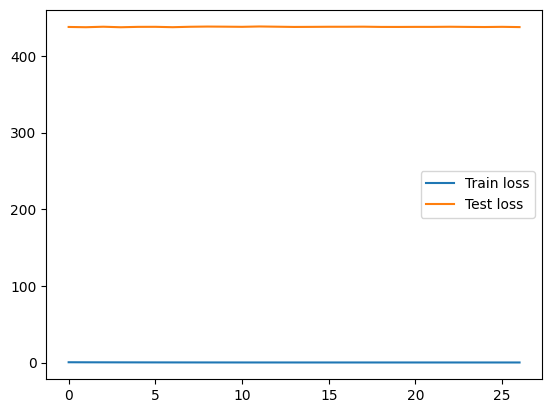

In [9]:
model = grid_search(params, x_train, y_train, hold_out_val, x_test, y_test)
# model.summary()
# test_model(model, x_test, y_test)

42/42 [==============================] - 0s 1ms/step


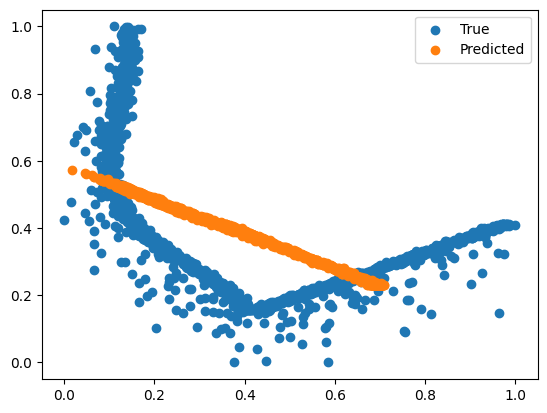

In [10]:
# y_train_rescaled = scaler.inverse_transform(y_train)
# print(y_train.shape)

plt.scatter(y_train[:, 0], y_train[:, 1], label="True")
pred = model.predict(x_train)
# pred = scaler.inverse_transform(pred)
plt.scatter(pred[:, 0], pred[:, 1], label = "Predicted")
plt.legend()
plt.show()